### Problem - use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.
<hr>


- On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

- While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

- In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).


#### Goal
It is your job to predict if a passenger survived the sinking of the Titanic or not.
For each in the test set, you must predict a 0 or 1 value for the variable.

#### Metric
Your score is the percentage of passengers you correctly predict. This is known as accuracy.


#### Data Dictionary
<br/>
<table width="100%">
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>




#### Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

### Load useful libraries

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.metrics import SCORERS, confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier, Perceptron
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### Load files

In [3]:
data = pd.read_csv("../input/titanic/train.csv")

In [4]:
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns in Data")

There are 891 rows and 12 columns in Data


### Check for missing values

In [5]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- Column Age, Cabin and Embarked have missing values

### Changing traget variable value from 0, 1 to "Not Survived" and "Survived"

In [6]:
data['Survived'] = data['Survived'].apply(lambda x: 'Not Survived' if x == 0 else 'Survived')

In [7]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,Not Survived,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,Survived,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,Survived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,Survived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,Not Survived,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Drop Cabin column


Cabin column have almost 70% na values. so it's better to remove it.

In [8]:
data.drop(columns=['Cabin'], inplace=True)

### How many people survived

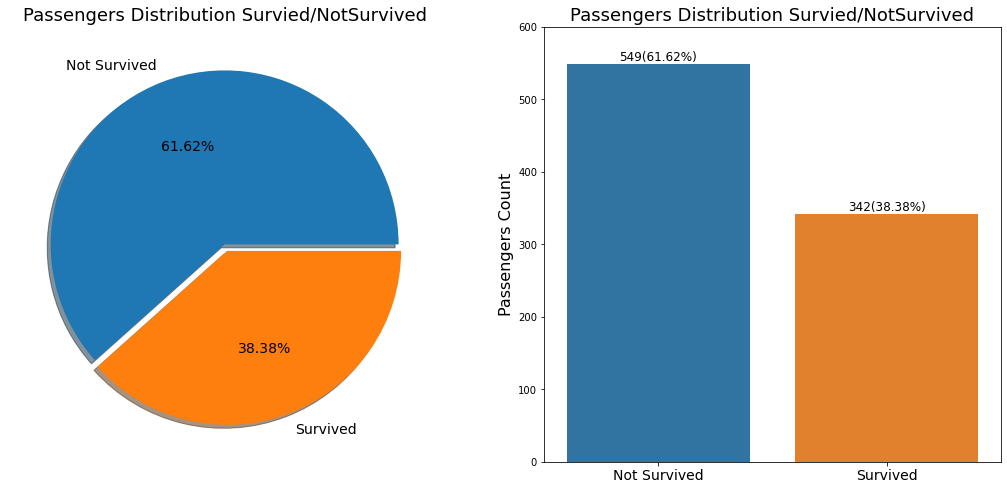

In [9]:
data_group_by_survived = data.groupby(['Survived'])["Name"].agg({'count'}).reset_index()


f,ax=plt.subplots(1,2, figsize=(18,8))
ax[0].pie(data_group_by_survived['count'], 
       labels=data_group_by_survived['Survived'], 
       shadow=True,
       autopct='%1.2f%%',
       explode=(0, .04),
       textprops={'color': 'black', 'fontsize': 14})
ax[0].set_title("Passengers Distribution Survied/NotSurvived", fontsize=18)
ax[0].set_ylabel('')

g = sns.countplot('Survived',data=data,ax=ax[1])
for p in g.patches:
    ax[1].annotate('{:}({:.2f}%)'.format(p.get_height(), (p.get_height()/len(data))*100), 
                   (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', 
                    fontsize=12)

ax[1].set_yticks(range(0, 601, 100))
ax[1].set_xlabel("")
ax[1].set_ylabel("Passengers Count", fontsize=16)
ax[1].set_title('Passengers Distribution Survied/NotSurvived', fontsize=18)
ax[1].set_xticklabels(["Not Survived", "Survived"],fontsize=14)
ax[1].set_ylabel("Passengers Count", fontsize=16)

plt.show()

- clearly showing Out of 891 passengers there are only 342(38.38%) survived

### Survived by Sex

In [10]:
data.groupby(['Sex','Survived'])['Survived'].agg({'count'}).reset_index()

,Sex,Survived,count
0,female,Not Survived,81
1,female,Survived,233
2,male,Not Survived,468
3,male,Survived,109


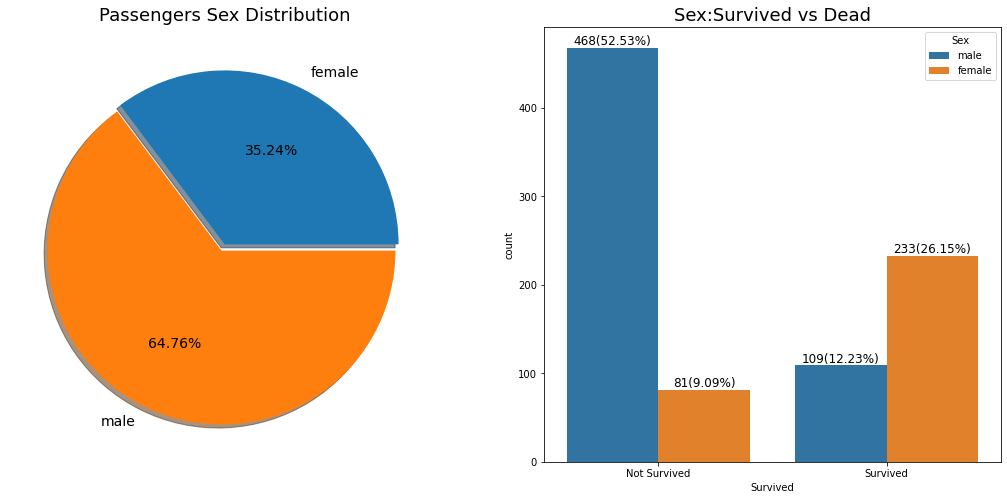

In [11]:
data_group_by_sex = data.groupby(['Sex'])["Name"].agg({'count'}).reset_index()

f,ax=plt.subplots(1,2, figsize=(18,8))
ax[0].pie(data_group_by_sex['count'], 
       labels=data_group_by_sex['Sex'], 
       shadow=True,
       autopct='%1.2f%%',
       explode=(0, .04),
       textprops={'color': 'black', 'fontsize': 14})
ax[0].set_title("Passengers Sex Distribution", fontsize=18)
ax[0].set_ylabel('')
    
g2 = sns.countplot('Survived', hue="Sex", data=data,ax=ax[1])
for p in g2.patches:
    ax[1].annotate('{:}({:.2f}%)'.format(p.get_height(), (p.get_height()/len(data))*100), 
                   (p.get_x()+0.2, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', 
                    fontsize=12)
ax[1].set_title('Sex:Survived vs Dead', fontsize=18)
plt.show()

In [12]:
233/(233+109), 109/(233+109)

(0.6812865497076024, 0.31871345029239767)

- There are 34.24% female passengers and 64.76% male passengers.
- Out of 891 passengers total 233 female passenger survived(which is 26.15% of whole passengers)
- Out of 891 passengers total 109 male passenger survived(which is 12.23% of whole passengers)
- Out of 342 survived passengers, 233 are female(which is 68.13% of total survived passengers)
- Out of 342 survived passengers, 109 are male(which is 31.87% of total survived passengers)

### Survived by Pclass

In [13]:
data.groupby(['Pclass','Survived'])['Survived'].agg({'count'}).reset_index()

,Pclass,Survived,count
0,1,Not Survived,80
1,1,Survived,136
2,2,Not Survived,97
3,2,Survived,87
4,3,Not Survived,372
5,3,Survived,119


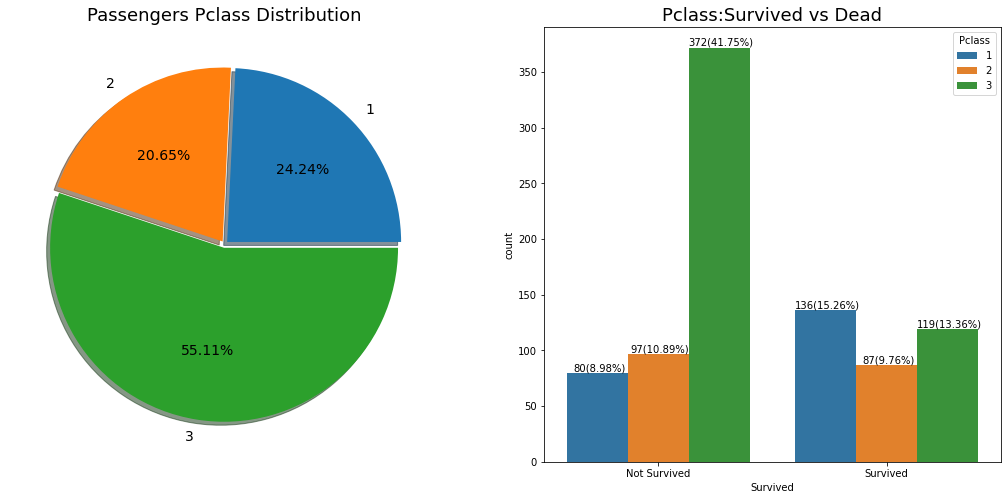

In [14]:
data_group_by_pclass = data.groupby(['Pclass'])["Name"].agg({'count'}).reset_index()

f,ax=plt.subplots(1,2, figsize=(18,8))
ax[0].pie(data_group_by_pclass['count'], 
       labels=data_group_by_pclass['Pclass'], 
       shadow=True,
       autopct='%1.2f%%',
       explode=(.02, .02, .02),
       textprops={'color': 'black', 'fontsize': 14})
ax[0].set_title("Passengers Pclass Distribution", fontsize=18)
ax[0].set_ylabel('')
    
g2 = sns.countplot('Survived', hue="Pclass", data=data,ax=ax[1])
for p in g2.patches:
    ax[1].annotate('{:}({:.2f}%)'.format(p.get_height(), (p.get_height()/len(data))*100), 
                   (p.get_x()+0.14, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', 
                    fontsize=10)
ax[1].set_title('Pclass:Survived vs Dead', fontsize=18)
plt.show()

- Out of 891 passengers there are 216 (24.24%) passengers in class 1
- Out of 891 passengers there are 184 (20.65%) passengers in class 2
- Out of 891 passengers there are 491 (55.11%) passengers in class 3

- Out of 891 passengers 136 survived(15.26%) belongs to class 1
- Out of 891 passengers 87 survived(09.76%) belongs to class 2
- Out of 891 passengers 119 survived(13.36%) belongs to class 3

- Out of 891 passengers 80 not survived(8.8%) belongs to class 1
- Out of 891 passengers 97 not survived(10.89%) belongs to class 2
- Out of 891 passengers 372 not survived(41.75%) belongs to class 3

- Out of 342 survived passengers 136 (39.76%) belongs to class 1
- Out of 342 survived passengers 87 (25.43%) belongs to class 2
- Out of 342 survived passengers 139 (34.79%) belongs to class 3

- Out of 216 passengers in class 1, 136 survived which is 62.96% 
- Out of 184 passengers in class 2, 87 survived which is 45.65% 
- Out of 391 passengers in class 3, 119 survived which is 30.43% 

### Chart for Pclass, Survived, sex

In [15]:
data.groupby(['Pclass', 'Sex','Survived'])['Survived'].count()

Pclass  Sex     Survived    
1       female  Not Survived      3
                Survived         91
        male    Not Survived     77
                Survived         45
2       female  Not Survived      6
                Survived         70
        male    Not Survived     91
                Survived         17
3       female  Not Survived     72
                Survived         72
        male    Not Survived    300
                Survived         47
Name: Survived, dtype: int64

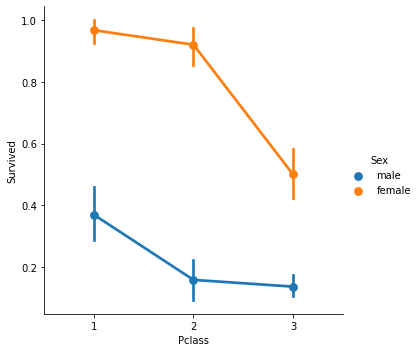

In [16]:
data_fplot_pc_du_sx = data[["Pclass", 'Survived', "Sex"]]
data_fplot_pc_du_sx["Survived"] = data_fplot_pc_du_sx["Survived"].apply(lambda x: 1 if x == 'Survived' else 0)
sns.factorplot('Pclass','Survived',hue='Sex',data=data_fplot_pc_du_sx)
plt.show()

- It is clear from factorplot, female have higher survival rate in all classes.
- In class 1, 2 female passengers have more than 90% chance of survival
- In class 2, 3 male passengers have veyr low chance

### Depp dive into age

In [17]:
print('Oldest Passenger was of:',data['Age'].max(),'Years')
print('Youngest Passenger was of:',data['Age'].min(),'Years')
print('Average Age on the ship:',data['Age'].mean(),'Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


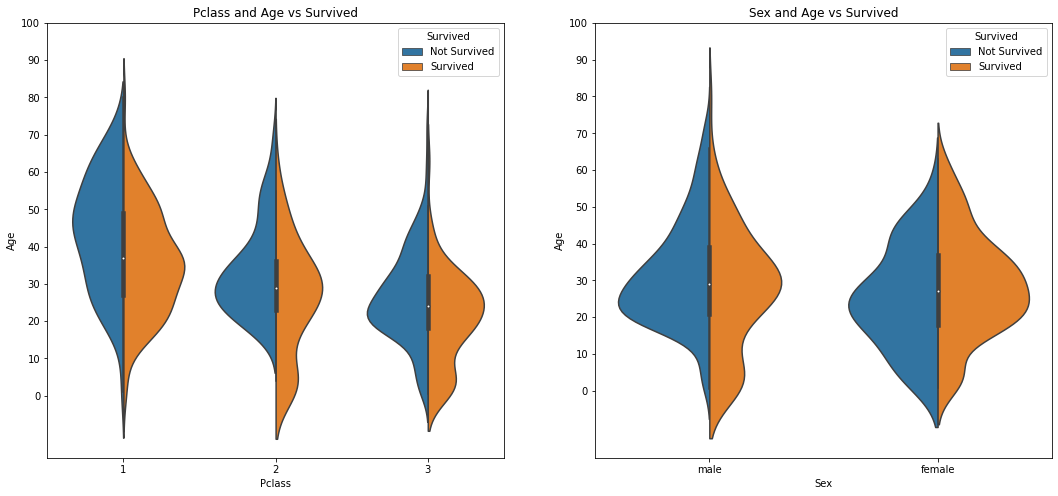

In [18]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))


sns.violinplot("Sex","Age", hue="Survived", data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

- As we know Age have around 177 missing values.
- We can create a new feature Salutation/Initial from Name. And then fill age based on Name Initial.

### Creating new feature Name Initial

In [19]:
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)


In [20]:
data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,Not Survived,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,Survived,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,Survived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss


In [21]:
data.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [22]:
## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [23]:
data.Age.isnull().any() #So no null values left finally

False

### Age distribution for both survived and not survived

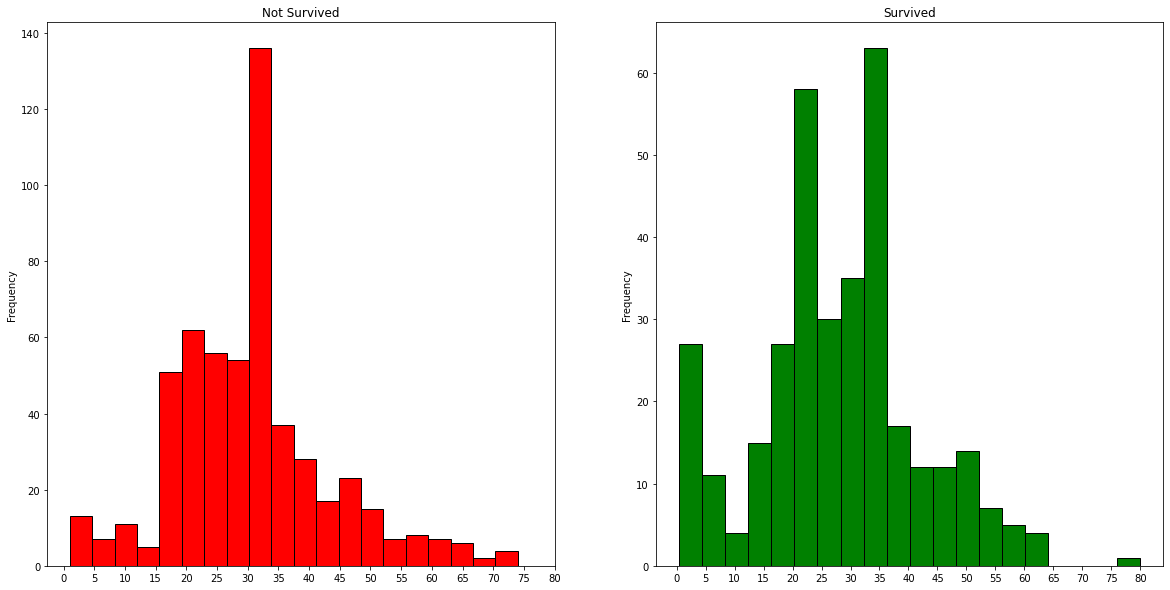

In [24]:
f,ax=plt.subplots(1,2,figsize=(20,10))

data[data['Survived']=='Not Survived'].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Not Survived')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)

data[data['Survived']=='Survived'].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

- As you can see passengers age 0<=5 have survived more.
- passengers age > 75 survived
- most people between 30 to 40 not survuved

### Survived by Embarked

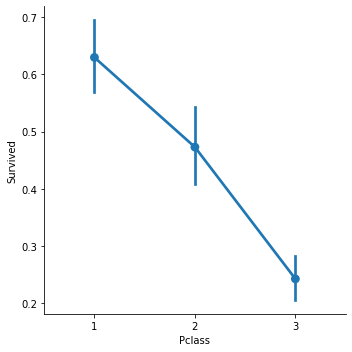

In [25]:
data_fplot_pc_du_sx = data[["Pclass", 'Survived', "Sex"]]
data_fplot_pc_du_sx["Survived"] = data_fplot_pc_du_sx["Survived"].apply(lambda x: 1 if x == 'Survived' else 0)

sns.factorplot('Pclass','Survived',data=data_fplot_pc_du_sx)
plt.show()

- Passengers who boared from S port have lowest survival chance
- C port have highest chance of survival

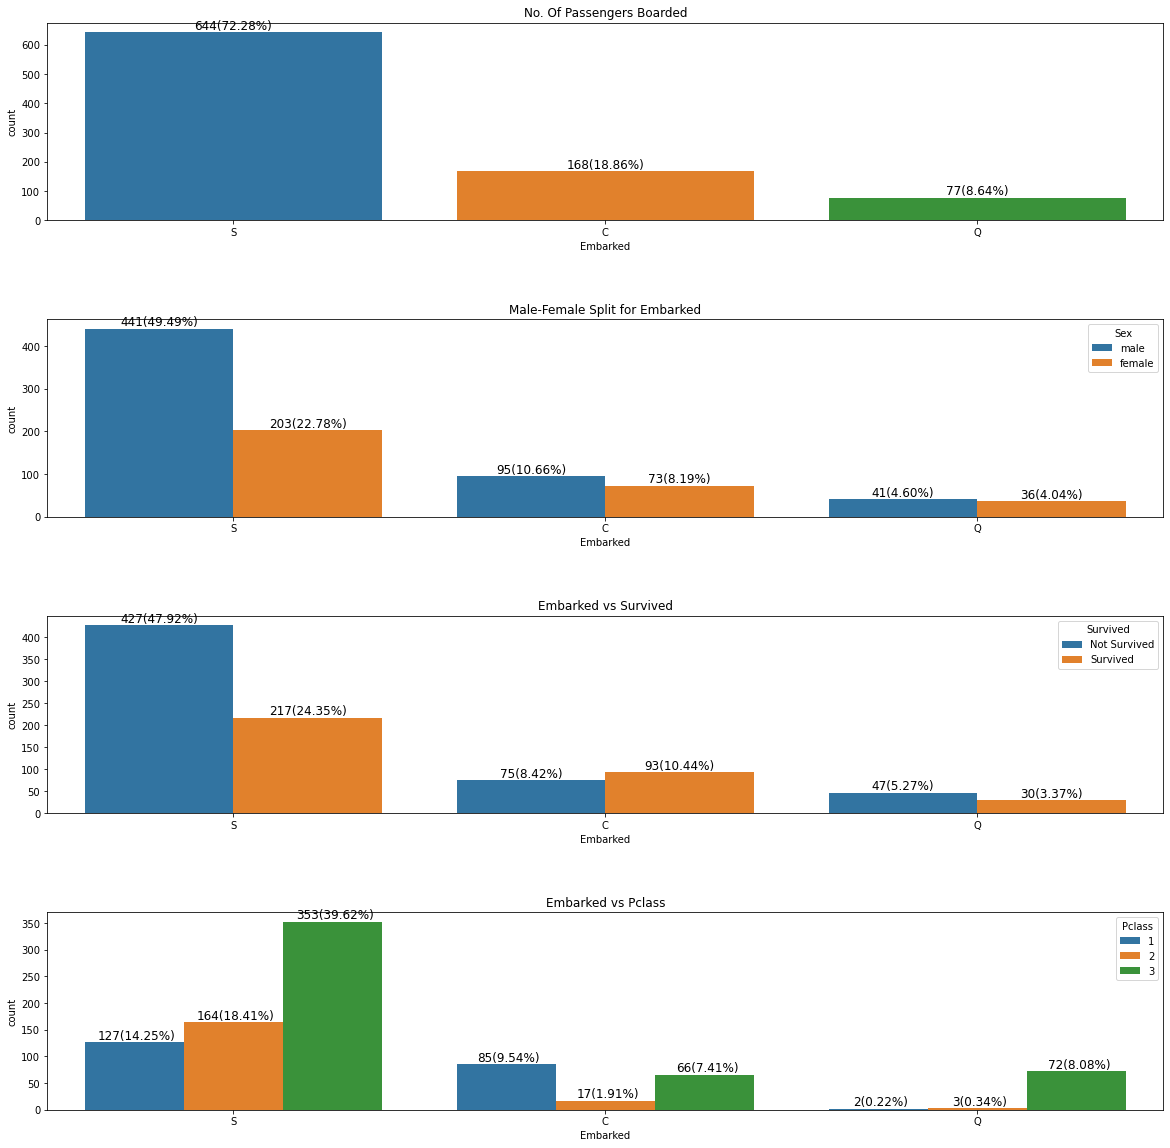

In [26]:
f,ax=plt.subplots(4,1,figsize=(20,20))

g1 = sns.countplot('Embarked',data=data,ax=ax[0])
ax[0].set_title('No. Of Passengers Boarded')
for p in g1.patches:
    ax[0].annotate('{:}({:.2f}%)'.format(p.get_height(), (p.get_height()/len(data))*100), 
                   (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', 
                    fontsize=12)


g2 = sns.countplot('Embarked',hue='Sex',data=data,ax=ax[1])
ax[1].set_title('Male-Female Split for Embarked')
for p in g2.patches:
    ax[1].annotate('{:}({:.2f}%)'.format(p.get_height(), (p.get_height()/len(data))*100), 
                   (p.get_x()+0.2, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', 
                    fontsize=12)


g3 = sns.countplot('Embarked',hue='Survived',data=data,ax=ax[2])
ax[2].set_title('Embarked vs Survived')
for p in g3.patches:
    ax[2].annotate('{:}({:.2f}%)'.format(p.get_height(), (p.get_height()/len(data))*100), 
                   (p.get_x()+0.2, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', 
                    fontsize=12)


g4 = sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[3])
ax[3].set_title('Embarked vs Pclass')
for p in g4.patches:
    ax[3].annotate('{:}({:.2f}%)'.format(p.get_height(), (p.get_height()/len(data))*100),
                   (p.get_x()+0.14, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', 
                    fontsize=12)

plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

- Out of 891 passengers, 644(72.28%) boarded from S embarked
- Out of 891 passengers, 168(18.86%) boarded from C embarked
- Out of 891 passengers, 077(08.64%) boarded from Q embarked

- Out of 891 passengers, 441(49.49%) male and 203(22.78%) female boarded from S embarked
- Out of 891 passengers, 095(10.66%) male and 073(08.19%) female boarded from S embarked
- Out of 891 passengers, 041(04.60%) male and 036(04.04%) female boarded from S embarked

- Out of 891 passengers, 217 (24.35%) survived from S embarked
- Out of 891 passengers, 093 (10.44%) survived from C embarked
- Out of 891 passengers, 030 (03.37%) survived from Q embarked

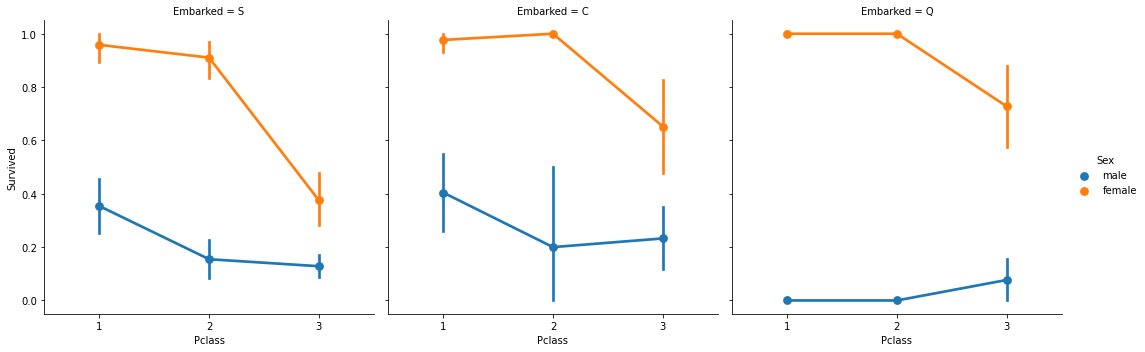

In [27]:
data_fplot_pc_du_sx = data[["Pclass", 'Survived', "Sex", "Embarked"]]
data_fplot_pc_du_sx["Survived"] = data_fplot_pc_du_sx["Survived"].apply(lambda x: 1 if x == 'Survived' else 0)


sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data_fplot_pc_du_sx)
plt.show()

 - female boarded from port C,Q, S and class 1,2 have almost 100% chance of survival.
 - Male boarded from port Q an class 1,2 have 0% chance of survival
 - Male boarded from port C and class 1 have 40% chnace of survival

In [28]:
data['Embarked'].mode()

0    S
dtype: object

In [29]:
data['Embarked'].fillna(data['Embarked'].mode()[0],inplace=True)

### Survived by Fare

In [30]:
print('Highest Fare was:',data['Fare'].max())
print('Lowest Fare was:',data['Fare'].min())
print('Average Fare was:',data['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


- lowest fare is 0.0

In [31]:
data.groupby(['Pclass'])['Fare'].agg({'min', 'mean', 'max'}).reset_index()

,Pclass,max,mean,min
0,1,512.3292,84.154687,0.0
1,2,73.5000,20.662183,0.0
2,3,69.5500,13.675550,0.0


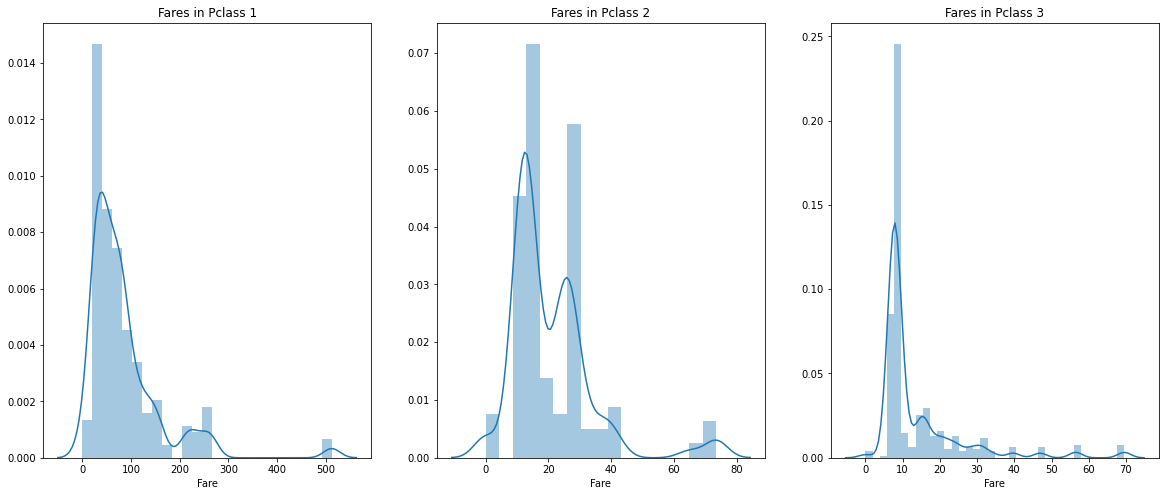

In [32]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')

sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')

sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

- Fare for class 1 between 0 to 512.3292 and average is 84.15
- Fare for class 2 between 0 to 073.5000 and average is 20.66
- Fare for class 3 between 0 to 069.5500 and average is 13.67

### Create new feature age_band

In [33]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4

In [34]:
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')#checking the number of passenegers in each band


,Age_band
1,382
2,325
0,104
3,69
4,11


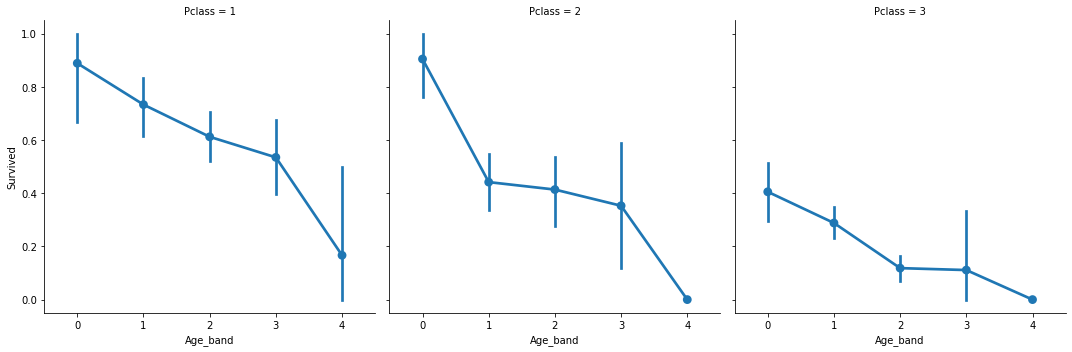

In [35]:
data_fplot_pc_du_sx = data[["Pclass", 'Survived', "Age_band"]]
data_fplot_pc_du_sx["Survived"] = data_fplot_pc_du_sx["Survived"].apply(lambda x: 1 if x == 'Survived' else 0)


sns.factorplot('Age_band','Survived',data=data_fplot_pc_du_sx,col='Pclass')
plt.show()

- Age_band 4 have lowest or no chance to survive
- Age_band 0,1,2,3 have 60% ch1nce of survival in class 1
- Age_band 1 have 90% chance of survival in class 1

### Create new feature Family Size

In [36]:
data['Family_Size']=1
data['Family_Size']=data['Parch']+data['SibSp']#family size


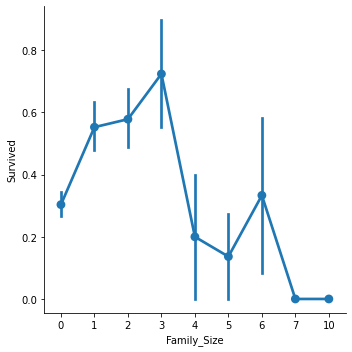

In [37]:
data_fplot_pc_du_sx = data[["Family_Size", 'Survived']]
data_fplot_pc_du_sx["Survived"] = data_fplot_pc_du_sx["Survived"].apply(lambda x: 1 if x == 'Survived' else 0)


sns.factorplot('Family_Size','Survived',data=data_fplot_pc_du_sx)
plt.show()

### Create new feature Fare range

In [38]:
data['Survived'] = data['Survived'].apply(lambda x: 0 if x == 'Not Survived' else 1)

In [39]:
data['Fare_Range']=pd.qcut(data['Fare'],4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [40]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

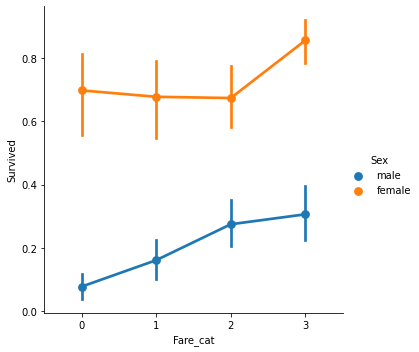

In [41]:
sns.factorplot('Fare_cat','Survived',data=data,hue='Sex')
plt.show()

- female have more than 70% chance of survival irrespective of Fare category
- as fare increases chance of survival increases

### Encoding features

In [42]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

### Drop unused features

In [43]:
data.drop(['Name','Age','Ticket','Fare','Fare_Range','PassengerId'],axis=1,inplace=True)

### Check correlation between features

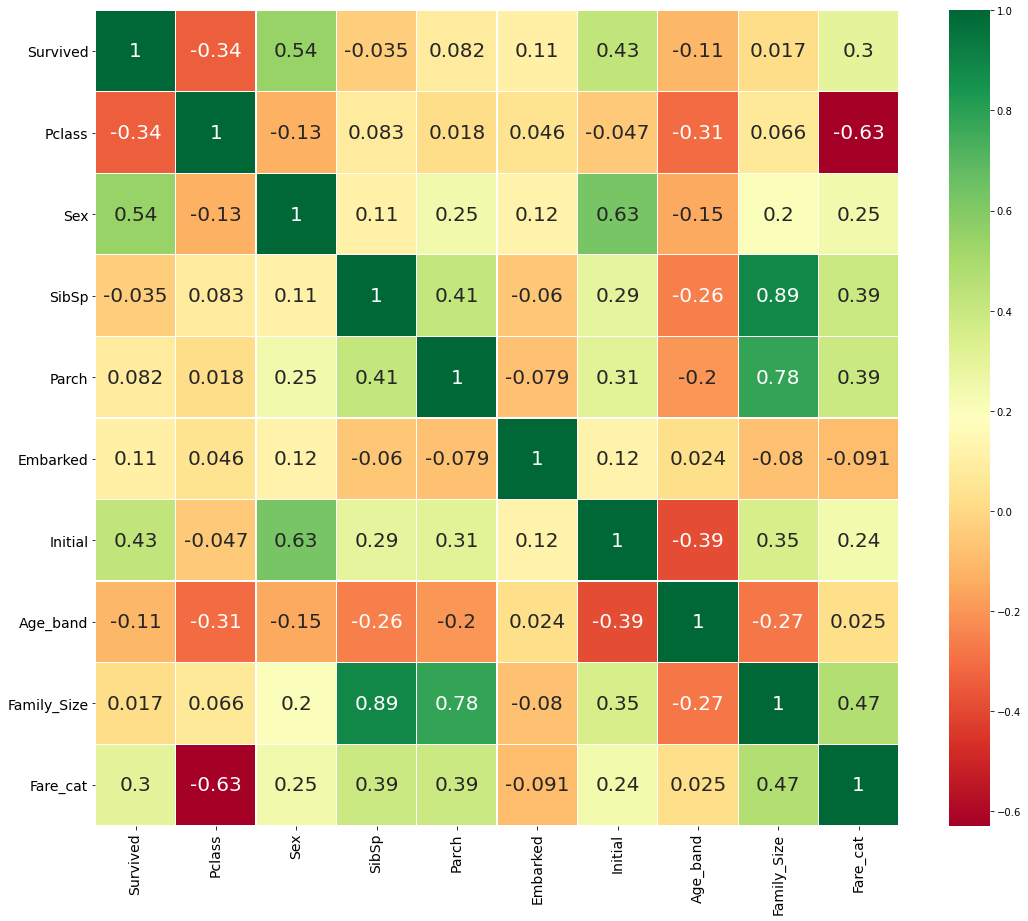

In [44]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

- Target variable have positive correlation with Fare_cat, Initial, Sex, Embarked
- Target variable have negative correlation with Age_band, Pclass

### Create feature, target variable

In [45]:
X = data.drop(columns=['Survived'])
y = data['Survived']

### Scale data

In [46]:
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=.25, shuffle=True)

In [48]:
def model_name(key):
    model_dict = {
        'lrc': "LogisticRegression", 
        'pac': "PassiveAggressiveClassifier",
        'rdc': "RidgeClassifier",
        'sgc': "SGDClassifier",
        'pcn': "Perceptron",
        'gpc': "GaussianProcessClassifier",
        'lda': "LinearDiscriminantAnalysis",
        'qda': "QuadraticDiscriminantAnalysis",
        'knn': "KNeighborsClassifier",
        'dtc': "DecisionTreeClassifier", 
        'etc': "ExtraTreesClassifier", 
        'knn': "KNeighborsClassifier",
        'gnb': "GaussianNB",
        'bnb': "BernoulliNB",
        'rfc': "RandomForestClassifier",
        'svc': "SVC",
        'lvc': "LinearSVC",
        'nvc': "NuSVC",
        'bgc': "BaggingClassifier",
        'abc': "AdaBoostClassifier",
        'gbc': "GradientBoostingClassifier",
        'lgb': "LGBMClassifier",
        'cgb': "CatBoostClassifier",
        'xgb': "XGBClassifier"
    }
    return model_dict[key]



def init(X, y, scoring='accuracy'):    
    result = pd.DataFrame(columns=['model', f'mean-{scoring}', f'std-{scoring}'])
    
    skf = StratifiedKFold(n_splits=10)
    model_dict = {
        'lrc': LogisticRegression(), 
        'pac': PassiveAggressiveClassifier(),
        'rdc': RidgeClassifier(),
        'sgc': SGDClassifier(),
        'pcn': Perceptron(),
        'gpc': GaussianProcessClassifier(),
        'lda': LinearDiscriminantAnalysis(),
        'qda': QuadraticDiscriminantAnalysis(),
        'knn': KNeighborsClassifier(),
        'dtc': DecisionTreeClassifier(), 
        'etc': ExtraTreesClassifier(), 
        'knn': KNeighborsClassifier(),
        'gnb': GaussianNB(),
        'bnb': BernoulliNB(),
        'rfc': RandomForestClassifier(),
        'svc': SVC(),
        'lvc': LinearSVC(),
        'nvc': NuSVC(),
        'bgc': BaggingClassifier(),
        'abc': AdaBoostClassifier(),
        'gbc': GradientBoostingClassifier(),
        'lgb': LGBMClassifier(),
        'cgb': CatBoostClassifier(verbose=0),
        'xgb': XGBClassifier()
    }

    for key in tqdm(model_dict.keys()):
        res = cross_val_score(model_dict[key], X, y=y, scoring=scoring, cv=skf, n_jobs=-1, verbose=0)
        res_p = pd.DataFrame(data={
            'model': [key],
            f'mean-{scoring}': [res.mean()],
            f'std-{scoring}': [res.std()]
        })
        result = pd.concat([result, res_p], axis=0)
    result = result.sort_values(by=[f'mean-{scoring}'], ascending=False)
    
    fig,ax =  plt.subplots(figsize=(20, 8), sharey=True)
    plt.title(f"Model vs mean {scoring}")
    auc_chart = sns.barplot(ax = ax, x='model', y=f'mean-{scoring}', data=result)
    for p in auc_chart.patches:
        auc_chart.annotate('{:.4f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=9)
    
    ax.set_ylim((0,1))
    plt.ylabel(f"Mean of {scoring}")
    plt.xlabel("Model")
    plt.show()
    
    fig,ax =  plt.subplots(figsize=(20, 8), sharey=True)
    plt.title(f"Model vs {scoring} standard deviation")
    std_chart = sns.barplot(ax = ax, x='model', y=f'std-{scoring}', data=result)
    for p in std_chart.patches:
        std_chart.annotate('{:.4f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=9)
    
    ylim_val = max(result[f'std-{scoring}']) + max(result[f'std-{scoring}'])*.1
    ax.set_ylim((0,ylim_val))
    plt.ylabel(f"Standard deviation of  {scoring}")
    plt.xlabel("Model")
    plt.show()
    
    return result

100%|██████████| 23/23 [00:21<00:00,  1.05it/s]


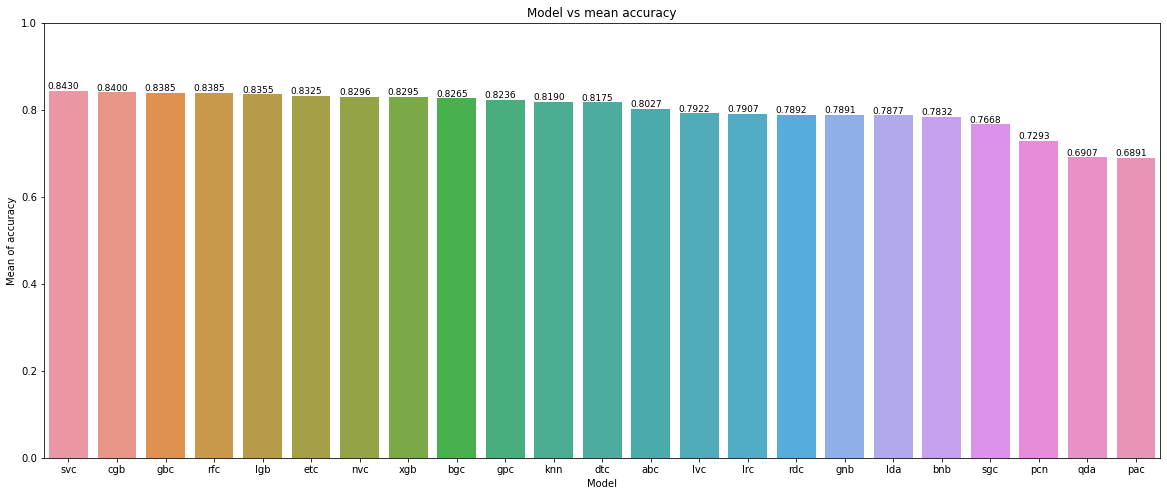

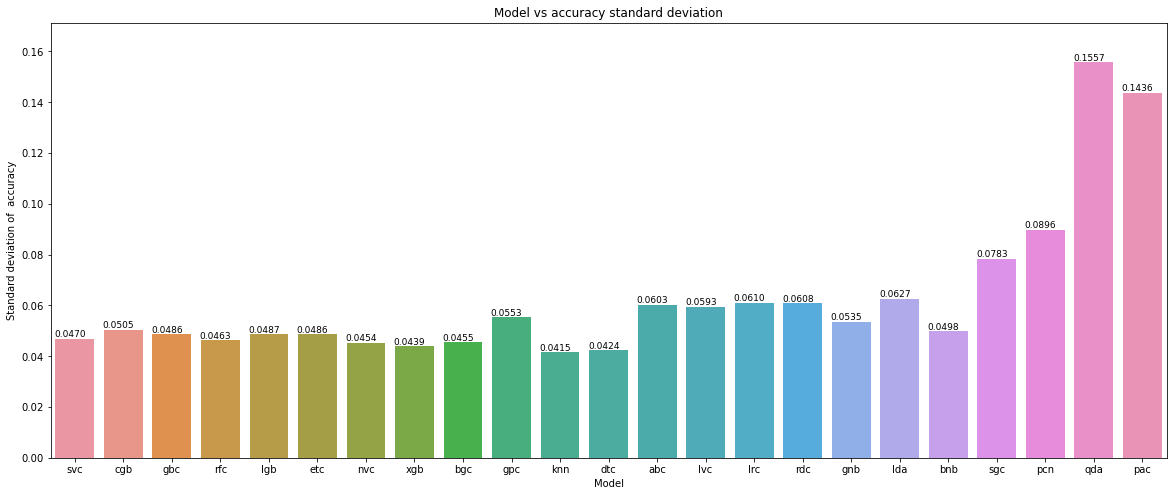

In [49]:
res = init(X_train, y_train, scoring='accuracy')

In [50]:
res

,model,mean-accuracy,std-accuracy
0,svc,0.843035,0.046957
0,cgb,0.840027,0.050497
0,gbc,0.838535,0.048577
0,rfc,0.838489,0.046261
0,lgb,0.835527,0.048653
0,etc,0.832519,0.048570
0,nvc,0.829557,0.045394
0,xgb,0.829534,0.043910
0,bgc,0.826504,0.045497
0,gpc,0.823609,0.055346


In [51]:
model_name('abc')

'AdaBoostClassifier'

In [52]:
%%time
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 123 ms


AdaBoostClassifier()

In [53]:
clf.score(X_train, y_train), clf.score(X_valid, y_valid)

(0.8218562874251497, 0.820627802690583)

In [54]:
roc_auc_score(y_train, clf.predict(X_train))

0.8089919599514565

In [55]:
accuracy_score(y_train, clf.predict(X_train))

0.8218562874251497

In [56]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       412
           1       0.78      0.75      0.76       256

    accuracy                           0.82       668
   macro avg       0.81      0.81      0.81       668
weighted avg       0.82      0.82      0.82       668



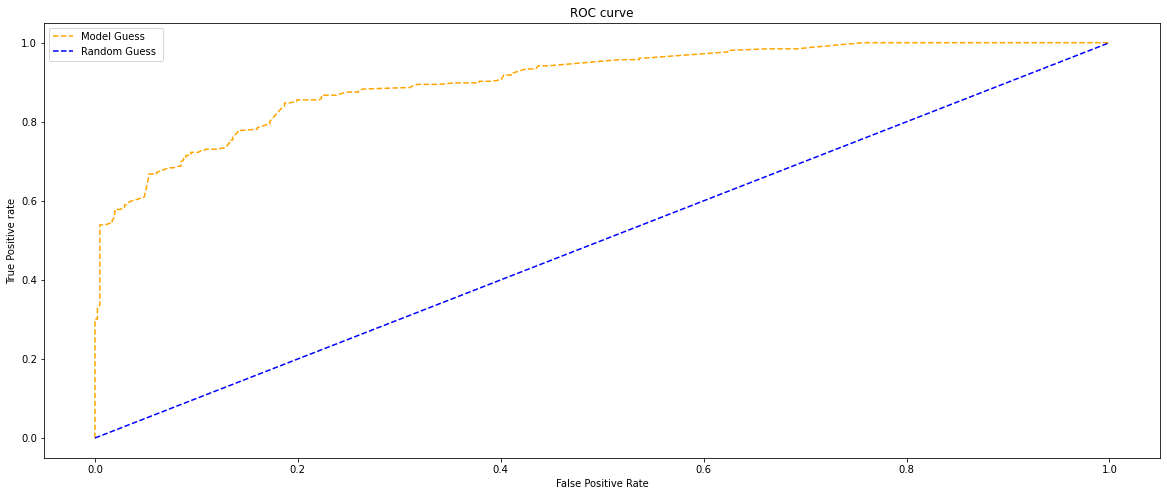

In [57]:
pred_prob1 = clf.predict_proba(X_train)

fpr1, tpr1, thresh1 = roc_curve(y_train, pred_prob1[:,1], pos_label=1)


# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y))]
p_fpr, p_tpr, _ = roc_curve(y, random_probs, pos_label=1)

# plot roc curves
fig,ax =  plt.subplots(figsize=(20, 8), sharey=True)
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Model Guess')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='Random Guess ')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();